# Sample Notebook 1 for Picasso

## Welcome to Picasso sample notebooks
The jupyter notebooks show the user interface for using Picasso as a Python package installed from PyPI: https://pypi.org/project/picassosr/. For detailed documentation of Picasso functionalities, especially when using Picasso GUI, please refer to https://picassosr.readthedocs.io/en/latest/index.html.

This notebook shows some basic interaction with the ``picasso`` library for localizing raw movies. It assumes to have a working picasso installation, for example, from PyPI (see: https://github.com/jungmannlab/picasso?tab=readme-ov-file#via-pypi).

The sample data was created using Picasso:Simulate.

In [1]:
%matplotlib inline
from picasso import io, localize, gausslq
path = "data/raw_movie.raw"  # Picasso supports multiple formats, including .raw and .ome.tif
movie, info = io.load_movie(path)
print(f"{movie.shape[0]} frames, width: {movie.shape[1]} pixels, height: {movie.shape[2]} pixels")

5000 frames, width: 32 pixels, height: 32 pixels


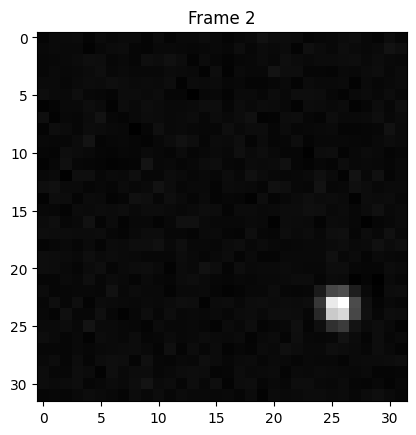

In [2]:
# plot example frame
import matplotlib.pyplot as plt
plt.style.use("default")
frame = 2
plt.imshow(movie[frame], cmap="gray")
plt.title(f"Frame {frame}")
plt.show()
plt.close()

## First step of the analysis is spot identification - finding positions of the single-molecule emitters

In [3]:
from picasso import localize
help(localize.identify)

Help on function identify in module picasso.localize:

identify(movie: 'np.ndarray', minimum_ng: 'float', box: 'int', threaded: 'bool' = True) -> 'pd.DataFrame'
    Identify local maxima in a movie and calculate the net
    gradient at those maxima. This function can run in a threaded or
    non-threaded mode.
    
    Parameters
    ----------
    movie : np.ndarray
        The input movie data as a 3D numpy array.
    minimum_ng : float
        The minimum net gradient for a spot to be considered.
    box : int
        The size of the box to extract around each spot.
    threaded : bool
        Whether to use threading for the identification process.
    
    Returns
    -------
    ids : pd.DataFrame
        Data frame containing the identified spots. Contains fields
        `frame`, `x`, `y`, and `net_gradient`.



In [4]:
min_ng = 3500  # minimum net gradient
box = 7  # box side length (pixels)
identifications = localize.identify(movie, min_ng, box, threaded=False)
identifications.head()

,frame,x,y,net_gradient
0,2,26,23,6020.876465
1,4,26,23,5863.750000
2,5,26,23,6260.936523
3,6,25,23,5956.500488
4,15,8,20,12072.339844


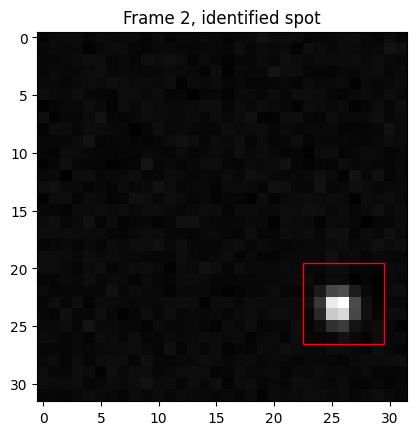

In [5]:
# plot example identification
from matplotlib.patches import Rectangle
iden_frame = identifications["frame"][0]
iden_x = identifications["x"][0]
iden_y = identifications["y"][0]
half_box = box / 2
plt.imshow(movie[iden_frame], cmap="gray")
rect = Rectangle(
    (iden_x - half_box, iden_y - half_box),
    box,
    box,
    facecolor="none",
    edgecolor="red",
)
plt.gca().add_patch(rect)
plt.title(f"Frame {frame}, identified spot")
plt.show()

## After idenfitication, it is time to fit 2D Gaussians to estimate single-molecule positions

In [6]:
# camera info will depend on your specific set up, see https://picassosr.readthedocs.io/en/latest/localize.html#example-default-camera
camera = {
    "Gain": 1,  # em gain
    "Baseline": 0.0,
    "Sensitivity": 1.0,
}

2399 spots were extracted.
Spots are an array of shape (2399, 7, 7)


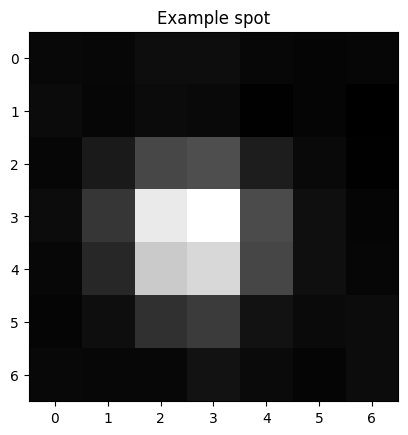

In [7]:
# start by extracting the idenitified spots
spots = localize.get_spots(movie, identifications, box, camera)
print(f"{len(spots)} spots were extracted.")
print(f"Spots are an array of shape {spots.shape}")

plt.imshow(spots[0], cmap="gray")
plt.title("Example spot")
plt.show()

In [8]:
# here we will use 2D Gaussian least-squares fitting, note the structure of the returned array
help(gausslq.fit_spots)
theta = gausslq.fit_spots(spots)
print(f"\nSpots fitted")

Help on function fit_spots in module picasso.gausslq:

fit_spots(spots: 'np.ndarray') -> 'np.ndarray'
    Fit multiple spots using least squares optimization. Each spot is
    a 2D array representing the pixel values of the spot image. The
    function returns a 2D array with the optimized parameters for each
    spot, where each row corresponds to a spot and the columns are the
    parameters in the following order: [x, y, photons, bg, sx, sy].
    
    Parameters
    ----------
    spots : np.ndarray
        A 3D array of shape (n_spots, size, size), where n_spots is the
        number of spots and size is the length of one side of the square
        spot image. Each slice along the first axis represents a single
        spot image.
    
    Returns
    -------
    theta : np.ndarray
        A 2D array with the optimized parameters for each spot. The
        columns correspond to [x, y, photons, bg, sx, sy].


Spots fitted


In [9]:
# convert to localizations
em = camera["Gain"] > 1
locs = gausslq.locs_from_fits(identifications, theta, box, em)
locs.head()

,frame,x,y,photons,sx,sy,bg,lpx,lpy,ellipticity,net_gradient
0,2,25.577694,23.390852,2726.332764,0.840439,0.852427,36.674107,0.024357,0.024668,0.014063,6020.876465
1,4,25.570528,23.395626,2662.613037,0.902836,0.860956,39.837715,0.026629,0.025511,0.046387,5863.750000
2,5,25.622553,23.387604,2728.365723,0.843607,0.871191,40.550835,0.024639,0.025362,0.031663,6260.936523
3,6,25.522259,23.429758,2828.362549,0.869489,0.917426,38.667923,0.024848,0.026085,0.052251,5956.500488
4,15,8.463214,20.024517,5371.983887,0.866434,0.890847,36.769318,0.017287,0.017726,0.027405,12072.339844


In [10]:
# save localizations with extra info
new_info = {
    "Generated by": "Picasso Sample Notebook Localize",
    "Box size": box,
    "Min net gradient": min_ng,
    "Fit method": "LQ, Gaussian",
}
info.append(new_info)
io.save_locs(path.replace(".raw", "_locs.hdf5"), locs, info)

## Alternatively, identification and fitting can be combined (as of v0.9.1 only MLE fitting is supported):

In [11]:
help(localize.localize)

Help on function localize in module picasso.localize:

localize(movie: 'np.ndarray', camera_info: 'dict', parameters: 'dict', threaded: 'bool' = True) -> 'pd.DataFrame'
    Localize (i.e., identify and fit) spots in a movie using
    the specified parameters.
    
    Parameters
    ----------
    movie : np.ndarray
        The input movie data as a 3D numpy array.
    camera_info : dict
        A dictionary containing camera information such as
        `Baseline`, `Sensitivity`, and `Gain`.
    parameters : dict
        A dictionary containing localization parameters, including:
        - `Min. Net Gradient`: Minimum net gradient for spot
          identification.
        - `Box Size`: Size of the box to cut out around each spot.
    threaded : bool, optional
        Whether to use threading for the identification process. Default
        is True.
    
    Returns
    -------
    locs : pd.DataFrame
        Data frame containing the localized spots. The fields include
        `frame`,

In [12]:
params = {
    "Min. Net Gradient": min_ng,
    "Box Size": box,
}
locs = localize.localize(movie, camera, params, threaded=False)
print("\nThese localizations can be saved with io.save_locs like above.")
locs.head()


These localizations can be saved with io.save_locs like above.


,frame,x,y,photons,sx,sy,bg,lpx,lpy,net_gradient,likelihood,iterations
0,2,28.596821,26.398203,2923.691895,0.830790,0.830790,33.875504,0.019759,0.019760,6020.876465,-32.481541,3
1,4,28.584661,26.393719,2743.913086,0.840332,0.840332,38.574310,0.021152,0.021154,5863.750000,-22.300774,3
2,5,28.619617,26.400311,2819.323730,0.822816,0.822816,39.072960,0.020344,0.020341,6260.936523,-23.326530,3
3,6,28.550863,26.418180,2901.973145,0.854136,0.854136,37.582787,0.020732,0.020734,5956.500488,-23.386925,3
4,15,11.484938,23.021534,5434.735840,0.829163,0.829163,36.334717,0.013692,0.013697,12072.339844,-29.331448,3
